# CAT-DOG IMAGE CLASSIFIER

##### LOAD IMAGE FILES

In [1]:
import random
import os

source = 'PetImages/'
class_img = ['Dog', 'Cat']

filename_list = []

# make a list with names of the images downloaded, cats and dogs
for _class in class_img:
    filename_list_class = os.listdir(source + _class)
    filename_list_class = [(_class + '/' + fname) for fname in filename_list_class if fname.endswith('.jpg')]
    filename_list += filename_list_class

# shuffle filename list
random.seed(42)
random.shuffle(filename_list)

filename_list = filename_list[:100]

print('Total number of files : ', len(filename_list))
filename_list[:10]

Total number of files :  100


['Cat/11242.jpg',
 'Dog/7312.jpg',
 'Dog/9636.jpg',
 'Cat/11240.jpg',
 'Dog/4628.jpg',
 'Dog/9274.jpg',
 'Cat/12325.jpg',
 'Dog/357.jpg',
 'Cat/5740.jpg',
 'Dog/9245.jpg']

##### STORE IMAGE FEATURES AND LABELS
`HINT`: Increasing the size of the input image (image_size) will keep more information to better train the model. However, this will also significantly increase the computational time for the training process.


LABEL : Cat


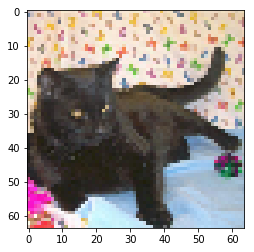

array([[[185., 182., 194.],
        [206., 203., 213.],
        [203., 212., 236.],
        ...,
        [175., 204., 220.],
        [188., 215., 231.],
        [180., 217., 233.]],

       [[161., 137., 119.],
        [190., 187., 199.],
        [182., 208., 232.],
        ...,
        [177., 205., 229.],
        [171., 206., 230.],
        [169., 202., 225.]],

       [[213., 214., 234.],
        [201., 213., 235.],
        [202., 215., 241.],
        ...,
        [180., 207., 233.],
        [168., 205., 227.],
        [111., 135., 178.]],

       ...,

       [[107., 149., 187.],
        [ 89., 133., 189.],
        [ 77.,  99., 161.],
        ...,
        [231., 203., 172.],
        [227., 201., 171.],
        [228., 203., 173.]],

       [[230., 249., 250.],
        [126., 161., 208.],
        [130., 159., 228.],
        ...,
        [226., 202., 174.],
        [226., 201., 174.],
        [219., 194., 168.]],

       [[178., 191., 220.],
        [ 90., 103., 232.],
        [ 77.,  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.transform import rescale, resize

# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

# this will store the information from every image
img_list = []       # feature
label_list = []     # labels

n_images = len(filename_list)
channels = 3         # three colors: RGB
image_size = 64      # image will be converted to 64x64 images

img_list = np.ndarray(shape=(n_images, image_size, image_size, channels), dtype=np.float32)
img_counter = 0

for fname in tqdm(filename_list):
    # read every single image as an array
    image = cv2.imread(source + fname, 1)
    
    # this TRY block will ignore the corrupted image files
    try:
        # resize every image to the desired size
        image = cv2.resize(image,(image_size,image_size))

        # build the list with feature data [RGB values]
        img_list[img_counter, :, :, :] = image

        # build the list with labels [cats | dogs]
        label_list.append(fname[:3])
        img_counter += 1
    
    except Exception as e:
        pass

# remove empty arrays
img_list = img_list[:n_images]

# plot a sample from the list of images [features]
print('LABEL : ' + label_list[0])
plt.imshow(cv2.cvtColor(img_list[0], cv2.COLOR_BGR2RGB).astype(np.uint8))
plt.show()

img_list[0]

##### APPLY ONE HOT ECONDING TO LABEL VALUES

In [3]:
for i in tqdm(range(len(label_list))):
    label = label_list[i]
    if label==class_img[0]:
        one_hot = [1,0]
    else:
        one_hot = [0,1]
    label_list[i] = one_hot
    
label_list = np.array(label_list)
label_list[:10]

array([[0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [4]:
n_images = img_counter          # total number of files : #####
training_size = 0.70            # training 70% | testing 30%

# define the training and the testing sets
X_train = img_list[:int(n_images * training_size)]
X_test = img_list[int(n_images * training_size):]

Y_train = label_list[:int(n_images * training_size)]
Y_test = label_list[int(n_images * training_size):]

# print the results
print('Feature Training set [X_train] :', X_train.shape)
print('Feature Testing set [X_test] :', X_test.shape)
print('Label Training set [Y_train] :', np.array(Y_train).shape)
print('Label Testing set [Y_test] :', np.array(Y_test).shape)

Feature Training set [X_train] : (70, 64, 64, 3)
Feature Testing set [X_test] : (30, 64, 64, 3)
Label Training set [Y_train] : (70, 2)
Label Testing set [Y_test] : (30, 2)


##### MODEL ARCHITECTURE

In [5]:
import tensorflow as tf

# this will set up a  seed in order in favor of reproducible results
def reset_graph(seed=127):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    
reset_graph()

# set up some parameters
keep_prob = 0.75
n_classes = len(class_img)      # [dogs | cats] = 2
receptive_field = 3             # kernel filter = 3x3
feature_map = 32

X = tf.placeholder(tf.float32, [None, image_size, image_size, channels])
Y = tf.placeholder(tf.float32, [None, n_classes])

# define some of the model's components
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

with tf.name_scope("cnn"):
    W_conv1 = weight_variable([receptive_field, receptive_field, channels, feature_map])  # [3,3,3,32]
    b_conv1 = bias_variable([feature_map])    # 32

    h_conv1 = tf.nn.relu(conv2d(X, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    W_conv2 = weight_variable([receptive_field, receptive_field, feature_map, feature_map*2])  # [3,3,32,64]
    b_conv2 = bias_variable([feature_map*2])   # 64

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([int(image_size/4 * image_size/4 * (feature_map*2)), feature_map**2]) # [65536,1024]
    b_fc1 = bias_variable([feature_map**2])  # 1024

    h_pool2_flat = tf.reshape(h_pool2, [-1, int(image_size/4 * image_size/4 * (feature_map*2))])  # [~,16384]
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([feature_map**2, n_classes])
    b_fc2 = bias_variable([n_classes])

    Y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

##### LEARNING RATE CONFIGURATION

In [ ]:
learning_rate = 0.01

# CHOOSE A DECAYING METHOD IN HERE
model_decay = 'polynomial'      # [exponential | inverse_time | natural_exponential | polynomial | none]

global_step = tf.Variable(0, trainable=False)
decay_rate = 0.90
decay_step = 10000

if model_decay == 'exponential':
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

elif model_decay == 'inverse_time':
    learning_rate = tf.train.inverse_time_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'natural_exponential':
    learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, decay_step, decay_rate)
    
elif model_decay == 'polynomial':
    end_learning_rate = 0.0001
    learning_rate = tf.train.polynomial_decay(learning_rate, global_step, decay_step, end_learning_rate, power=0.5)
    
else:
    decay_rate = 1.0
    learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_step, decay_rate)

print('Decaying Learning Rate : ', model_decay)

##### OPTIMIZER AND ACCURACY CONFIGURATION

In [ ]:
with tf.name_scope("loss"):
    #loss = tf.square(Y - Y_pred)                                                       # squared error
    #loss = tf.nn.softmax(logits=Y_pred)                                                # softmax
    #loss = tf.nn.log_softmax(logits=Y_pred)                                            # log-softmax
    #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=Y_pred, dim=-1) # cross-entropy
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=Y_pred)            # sigmoid-cross-entropy
    #loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=Y_pred)     # sparse-softmax-cross-entropy
    loss = tf.reduce_mean(loss, name='MSE')
    
with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)                     # SGD
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9) # MOMENTUM
    #optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)               # ADAGRAD
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate)              # ADADELTA
    #optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=1)      # RMS
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope("eval"):
    correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

##### MODEL EXECUTION

In [6]:
# define execution parameters
n_epochs = 50
display_epoch = 2
batch_size = 10
n_train = X_train.shape[0]
n_batches = int(n_train/batch_size)

# store results through every epoch iteration
acc_train_list = []
acc_test_list = []
learning_list = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(1, n_epochs+1)):
    avg_loss = 0    # store batches' average loss
    
    for batch in range(X_train.shape[0]):
        batch_index = np.random.choice(np.arange(X_train.shape[0]), batch_size)
        X_batch = X_train[np.array(batch_index)]
        Y_batch = Y_train[np.array(batch_index)]
        sess.run(training_op, feed_dict={X: X_batch, Y: Y_batch})
        
        _loss = sess.run(loss, feed_dict={X:X_batch, Y: Y_batch})
        avg_loss += _loss/n_batches
        
    if epoch % display_epoch == 0:
        
        _acc_train = sess.run(accuracy, feed_dict={X:X_train, Y: Y_train})
        _acc_test = sess.run(accuracy, feed_dict={X:X_test, Y:Y_test})
        
        with sess.as_default():
            assert tf.get_default_session() is sess
            acc_train_list.append(_acc_train)
            acc_test_list.append(_acc_test)
            learning_list.append(learning_rate.eval())

        print("Epoch: {:04}\tTrainAcc: {:06.5f}\tTestAcc: {:06.5f}\tLoss: {:06.5f}\tLearning: {:06.7f}".format(epoch,
                                                                                                               _acc_train,
                                                                                                               _acc_test,
                                                                                                               avg_loss,
                                                                                                               sess.run(learning_rate)))
        

Epoch: 0002	TrainAcc: 0.64286	TestAcc: 0.60000	Loss: 7.09705	Learning: 0.0099853
Epoch: 0004	TrainAcc: 0.67143	TestAcc: 0.60000	Loss: 6.90591	Learning: 0.0099705
Epoch: 0006	TrainAcc: 0.72857	TestAcc: 0.60000	Loss: 6.74102	Learning: 0.0099558
Epoch: 0008	TrainAcc: 0.77143	TestAcc: 0.53333	Loss: 6.59668	Learning: 0.0099412
Epoch: 0010	TrainAcc: 0.77143	TestAcc: 0.56667	Loss: 6.46911	Learning: 0.0099265
Epoch: 0012	TrainAcc: 0.82857	TestAcc: 0.40000	Loss: 6.30899	Learning: 0.0099119
Epoch: 0014	TrainAcc: 0.90000	TestAcc: 0.50000	Loss: 6.08602	Learning: 0.0098973
Epoch: 0016	TrainAcc: 0.84286	TestAcc: 0.43333	Loss: 5.97661	Learning: 0.0098827
Epoch: 0018	TrainAcc: 0.92857	TestAcc: 0.43333	Loss: 5.88043	Learning: 0.0098681
Epoch: 0020	TrainAcc: 0.97143	TestAcc: 0.50000	Loss: 5.76444	Learning: 0.0098536
Epoch: 0022	TrainAcc: 0.98571	TestAcc: 0.43333	Loss: 5.58953	Learning: 0.0098391
Epoch: 0024	TrainAcc: 0.95714	TestAcc: 0.50000	Loss: 5.51178	Learning: 0.0098246
Epoch: 0026	TrainAcc: 0.9857

##### VISUALIZE THE RESULTS

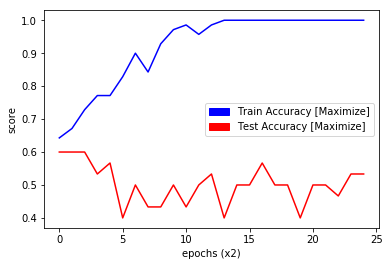

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

plt.plot(acc_train_list, color='blue')
plt.plot(acc_test_list, color='red')

plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('score');

##### LEARNING RATE EVOLUTION

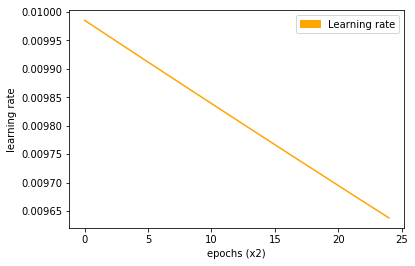

In [8]:
or_patch = mpatches.Patch(color='orange', label='Learning rate')
plt.legend(handles=[or_patch])

plt.plot(learning_list, color='orange');
plt.xlabel('epochs (x{})'.format(display_epoch))
plt.ylabel('learning rate');